<div style="font-size: 1.2em; background-color: #c0ad8b; padding: 1em; font-weight: bold; color: ;">
VPS: SSH - Webserver - Port fowarding - certificates - domaine name
</div>

<div style="text-align: center;">
    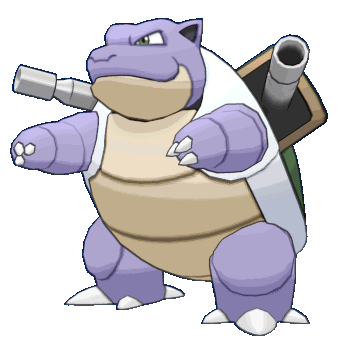
    <div style="text-align: left;">
        <a href="https://shinyhunters.com/images/shiny/9.gif" style="text-decoration: underline; color: #c0ad8b;">image source</a>
    </div>
</div>

<div style="font-size: 1.15em; background-color: #f8f8f8; padding: 1.2em;">
    <b>Tortank</b> est la forme finale de l'évolution de Carapuce. Puissant et robuste, Tortank est prêt à relever les défis les plus complexes. <br><br>
    Maintenant que nous avons maîtrisé les compétences de Carapuce et de Carabaffe, passons à l'étape finale. En tant que Tortank, nous explorerons des techniques avancées pour orchestrer et gérer les modèles de machine learning en production. <br><br>
    <b>Objectifs :</b>
    <ul>
        <li>Prise en main de MLflow pour le suivi et la gestion des modèles</li>
        <li>Détection des dérives de données en production</li>
        <li>Orchestration d'une pipeline de machine learning</li>
    </ul>
    C'est le moment de devenir des experts en gestion de modèles de machine learning en production. <b>Let's go!</b>
</div>

##### **1. SERVER SETUP WITH DOCKER COMPOSE AND NGINX REVERSE PROXY** ###

---

In [ ]:
ssh username@ADRESS_IP(10.78.90.65)
>MOTDEPASS

##### Step 1 : Create a shared Docker network

In [2]:
!docker network create tortank-shared-network

ff36a117faeddb60accc73f510ea4ae32732117aff00e1bc1b73acfdcc0bcee9


##### Step 2 : Reverse Proxy docker-compose.yml

In [4]:
%%file ./reverse-proxy/docker-compose.yml
version: '3.8'

services:
  reverse-proxy:
    image: nginx:latest
    container_name: reverse-proxy
    ports:
      - "7999:80"
    volumes:
      - ./nginx.conf:/etc/nginx/nginx.conf:ro
      - ./html:/etc/nginx/html:ro
    networks:
      - tortank-shared-network

networks:
  tortank-shared-network:
    external: true

Overwriting ./reverse-proxy/docker-compose.yml


In [4]:
%%file ./reverse-proxy/nginx.conf
events {}

http {
    server {
        listen 80;

        location /app1/ {
            proxy_pass http://frontend1:3001/;
        }
        location /app1/api/ {
            proxy_pass http://backend1:7001/;
        }
    }
}


Overwriting ./reverse-proxy/nginx.conf


##### Step 3 : App1 in a SEPARATE docker-compose

In [1]:
%%file ./app1/docker-compose.yml
version: '3.8'

services:
  backend1:
    container_name: backend1
    image: 13365920/catdog-api:latest
    ports:
      - "8000:3001"
    networks:
      - tortank-shared-network

  frontend1:
    container_name: frontend1
    image: 13365920/catdog-frontend:latest
    ports:
      - "8501:7001"
    networks:
      - tortank-shared-network
    depends_on:
      - backend1

networks:
  tortank-shared-network:
    external: true

Overwriting ./app1/docker-compose.yml


Run it:

In [2]:
!cd app1
!docker compose up -d

no configuration file provided: not found


##### Step 5 : Start reverse proxy

In [ ]:
!cd reverse-proxy
!docker compose up -d

##### **2. AUTOMATED DEPLOYMENT WITH DOCKER COMPOSE & GITHUB ACTIONS** ### 

Let's gon on github

**HANDS-ON SESSION**

Cet notebook a été rédigé grace au sources suivantes: 
* <a href="https://github.com/appleboy/ssh-action">https://github.com/appleboy/ssh-action</a>

name: Agent Widget CI/CD

on:
  push:
    branches:
      - main
  workflow_dispatch:

jobs:
  CI:
    runs-on: ubuntu-latest
    
    steps:
      - name: Checkout repository
        uses: actions/checkout@v2

      - name: Set up Node.js
        uses: actions/setup-node@v3
        with:
          node-version: '20.19.1'

      - name: Install dependencies
        run: |
          cd agentchat
          npm install

      - name: Build Vue app
        run: |
          cd agentchat
      #    npm run build

      # Remove testing due to hybrid aspect of server (vue + node)
      # - name: Run tests
      #   run: |
      #     cd agent-widget
      #     npm run check-lint

  CD:
    runs-on: ubuntu-latest
    needs: CI
    if: github.ref == 'refs/heads/main' && contains(github.event.head_commit.message, 'deploy')

    steps:
      - name: Checkout repository
        uses: actions/checkout@v2

      - name: Deploy to Server with SSH
        uses: appleboy/ssh-action@master
        # env:
        #   HOST_PORT: ${{ secrets.HOST_PORT }}
        with:
          timeout: 90m
          host: ${{ secrets.DEPLOY_HOST }}
          port: ${{ secrets.DEPLOY_PORT }}
          username: ${{ secrets.DEPLOY_USER }}
          password: ${{ secrets.DEPLOY_PASSWORD }}
          # envs: HOST_PORT
          script: |
            cd ~/FOLDER-SERVER
            git pull
            docker-compose down

            echo "[+] Building docker-compose services..."
            # docker-compose build | tee build.log &
            docker-compose build --progress=plain | tee build.log &

            # Wait loop to print output every few seconds to avoid silent timeout
            BUILD_PID=$!
            while kill -0 $BUILD_PID 2> /dev/null; do
              echo "[+] Still building at $(date)..."
              sleep 60
            done

            echo "[+] Build finished. Starting services..."
            docker-compose up -d
          # script: |
          #   cd ~/serenity-ia
          #   git pull
          #   docker-compose down
          #   docker-compose build
          #   docker-compose up -d

# docker-compose build --no-cache

##### **3. CERTIBOT:SSL/HTTPS** ###

To configure https on your reverse proxy, you can use Let's Encrypt with Certbot. Here are the general steps to do this:

1. Install Certbot on your server.
2. Obtain a SSL certificate using Certbot.
3. Configure Nginx to use the SSL certificate.
4. Test the SSL configuration.

https://certbot.eff.org/instructions

##### **3. AUTO script** ###

for i in {1..5}; do mkdir "folder$i"; done

mkdir folder{1..5}